In [9]:
# import modules
import os
#import sys
import pandas as pd
import numpy as np
#from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
# from sklearn.metrics import r2_score
# from sklearn.metrics import classification_report
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import ttest_ind
from scipy.stats import t
import joblib


In [10]:
current_dir = os.getcwd()
current_dir
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")
current_dir = os.getcwd()
current_dir
#set current working directory to H:\VScode\March Group\March_Team_Project\
os.chdir("H:\\VScode\\March Group\\March_Team_Project\\")

You set a new current directory


In [35]:
"""
       'State Code', 'County Code', 'Site Num', 'O3 Mean', 'O3 1st Max Value',
       'O3 1st Max Hour', 'O3 AQI', 'SO2 Mean', 'SO2 1st Max Value',
       'SO2 1st Max Hour', 'SO2 AQI', 'CO Mean', 'CO 1st Max Value',
       'CO 1st Max Hour', 'CO AQI', 'Year', 'year', 'AWND', 'PGTM', 'PRCP',
       'TAVG', 'TMAX', 'TMIN', 'TSUN', 'WDMV', 'WT01', 'WT02', 'WT03', 'WT04',
       'WT05', 'WT06', 'WT08', 'WT09', 'WT11', 'WT13', 'WT16', 'WT18', 'WT22',
       'WS_Elevation', 'CityDistance', 'O3_AQI_Group', 'SO2_AQI_Group',
       'CO_AQI_Group']
"""
#columns to be used in model
targets = ['O3_AQI_Group', 'SO2_AQI_Group', 'CO_AQI_Group', 'NO2_AQI_Group']

# weather columns for model building
weather_columns = ['Year', 'AWND', 'PGTM', 'PRCP', 'TAVG', 'TMAX', 'TMIN', 'WDMV',
                   'WT01', 'WT02', 'WT03', 'WT04', 'WT05', 'WT06', 'WT08', 'WT09', 'WT11', 'WT13',
                   'WT16', 'WT18', 'WT22', 'WS_Elevation', 'CityDistance', 'WS_Latitude', 'WS_Longitude']
# load Outputs/DashBoardData.zip'
merged_data = pd.read_csv("Outputs/DashBoardData.zip", compression='zip', low_memory=False)
# convert date columns to datetime
merged_data['Date'] = pd.to_datetime(merged_data['Date'])
# add date columns for model building
merged_data['Year'] = merged_data['Date'].dt.year
merged_data['Month'] = merged_data['Date'].dt.month
merged_data['Day'] = merged_data['Date'].dt.day
merged_data['DayOfWeek'] = merged_data['Date'].dt.dayofweek
merged_data['DayOfYear'] = merged_data['Date'].dt.dayofyear
merged_data['DayOfYear_cos'] = np.cos(2 * np.pi * merged_data['DayOfYear'] / 365)
merged_data['DayOfYear_sin'] = np.sin(2 * np.pi * merged_data['DayOfYear'] / 365)

# list of date fields
date_columns = ['Year', 'Month', 'Day', 'DayOfWeek', 'DayOfYear', 'DayOfYear_cos', 'DayOfYear_sin']

# filter merged_data for weather_columns and targets
merged_data_for_model = merged_data[weather_columns + targets + date_columns].copy()
del merged_data
# produce list of numeric and bool columns
numeric_columns = merged_data_for_model.select_dtypes(include=['float64', 'int64', 'bool']).columns
# create a list of columns with skewness greater than 1
skewness = merged_data_for_model[numeric_columns].skew()
skewness = skewness[skewness > 1]
skewness
# Columns with high skewness
skewed_columns = skewness.index.tolist()
# Columns not in skewness
remaining_columns =[col for col in numeric_columns if col not in skewed_columns]


Transform data to standardise data ranges and correct skewness

In [38]:
# Use scikit learn to apply transformations to the data to standardise the data and correct skewness
merged_data_corrected=merged_data_for_model.copy()
# apply power transformer to columns with skewness greater than 1
power_transformer = PowerTransformer()
# apply standard scaler to all numeric columns
scaler = StandardScaler()

# apply power transformer to columns with skewed columns
skew_pipeline = make_pipeline(PowerTransformer(), StandardScaler())

# chain the power transformer and standard scaler into a pipeline
column_transformer = ColumnTransformer(transformers=[
    ('skewed', skew_pipeline, skewed_columns),
    ('scaled', StandardScaler(), remaining_columns)
])

pipeline = Pipeline(steps=[('column_transformer', column_transformer)])
merged_data_transformed = pipeline.fit_transform(merged_data_corrected)
merged_data_transformed_df = pd.DataFrame(merged_data_transformed)


Compare Correlation models

In [39]:
# Compare the correlation matrix before and after the transformations

# convert transformed data to a dataframe
merged_data_transformed_df = pd.DataFrame(merged_data_transformed)
# perform correlation matrix on transformed data
correlation_matrix_transformed_corr = merged_data_transformed_df.corr()
correlation_matrix_transformed_corr = correlation_matrix_transformed_corr.round(2)

# perform correlation matrix on original data
correlation_matrix_original = merged_data_for_model[numeric_columns].copy().corr()
correlation_matrix_original = correlation_matrix_original.round(2)

# check that correlation_matrix_transformed_corr and correlation_matrix_original are the same shape
if correlation_matrix_transformed_corr.shape != correlation_matrix_original.shape:
    print('The correlation matrices have different shapes')
    # print the shapes of the correlation matrices
    print(f'The shape of the correlation matrix for the transformed data is {correlation_matrix_transformed_corr.shape}')
    print(f'The shape of the correlation matrix for the original data is {correlation_matrix_original.shape}')
    print('The program will stop')
    # stop the program
    exit()
else:
    print('The correlation matrices have the same shape')

print("NaNs in original:", correlation_matrix_original.isna().sum().sum())
print("NaNs in transformed:", correlation_matrix_transformed_corr.isna().sum().sum())

# performa a statistical test to determine if the correlation matrices are significantly different
# calculate the difference between the two correlation matrices
# Flatten the correlation matrices to 1D arrays
original_corr_values = correlation_matrix_original.values.flatten()
transformed_corr_values = correlation_matrix_transformed_corr.values.flatten()

print("Original correlation min/max:", original_corr_values.min(), original_corr_values.max())
print("Transformed correlation min/max:", transformed_corr_values.min(), transformed_corr_values.max())

mask = ~np.isnan(original_corr_values) & ~np.isnan(transformed_corr_values)
original_clean = original_corr_values[mask]
transformed_clean = transformed_corr_values[mask]

print("Original clean correlation min/max:", original_clean.min(), original_clean.max())
print("Transformed clean correlation min/max:", transformed_clean.min(), transformed_clean.max())

print("Number of valid values after cleaning:", len(original_clean), len(transformed_clean))
# Perform a t-test to compare the two correlation matrices
t_statistic, p_value = ttest_ind(original_clean, transformed_clean)

# Calculate degrees of freedom
degrees_of_freedom = len(original_clean) + len(transformed_clean) - 2

# Calculate the critical value for a 95% confidence level
critical_value = t.ppf(0.975, degrees_of_freedom)

# Determine if the null hypothesis is rejected
null_hypothesis_rejected = abs(t_statistic) > critical_value
# print the results
print(f'p-value: {p_value}')
print(f'degrees of freedom: {degrees_of_freedom}')
print(f't-statistic: {t_statistic}')
print(f'critical value: {critical_value}')
print(f'null hypothesis rejected: {null_hypothesis_rejected}')

# so the outcome of the t-test is that the correlation matrices are significantly different

The correlation matrices have the same shape
NaNs in original: 0
NaNs in transformed: 0
Original correlation min/max: -0.49 1.0
Transformed correlation min/max: -0.49 1.0
Original clean correlation min/max: -0.49 1.0
Transformed clean correlation min/max: -0.49 1.0
Number of valid values after cleaning: 900 900
p-value: 0.9739721409878785
degrees of freedom: 1798
t-statistic: -0.03263141305646353
critical value: 1.961284252515681
null hypothesis rejected: False


Linear Regression Model for NO2 AGI

Column to predict and relatives: NO2 AQI ['NO2 Units', 'NO2 Mean', 'NO2 1st Max Value', 'NO2 1st Max Hour', 'NO2 AQI', 'NO2_AQI_Range', 'NO2_AQI_Range_Description', 'NO2_AQI_Group'] ['NO2 Mean', 'NO2 1st Max Value', 'NO2 1st Max Hour', 'NO2 AQI', 'NO2_AQI_Group']
Output list of numeric columns: Index(['State Code', 'County Code', 'Site Num', 'O3 Mean', 'O3 1st Max Value',
       'O3 1st Max Hour', 'O3 AQI', 'SO2 Mean', 'SO2 1st Max Value',
       'SO2 1st Max Hour', 'SO2 AQI', 'CO Mean', 'CO 1st Max Value',
       'CO 1st Max Hour', 'CO AQI', 'Year', 'year', 'AWND', 'PGTM', 'PRCP',
       'TAVG', 'TMAX', 'TMIN', 'TSUN', 'WDMV', 'WT01', 'WT02', 'WT03', 'WT04',
       'WT05', 'WT06', 'WT08', 'WT09', 'WT11', 'WT13', 'WT16', 'WT18', 'WT22',
       'WS_Elevation', 'CityDistance', 'O3_AQI_Group', 'SO2_AQI_Group',
       'CO_AQI_Group'],
      dtype='object')
(46054, 43) (46054,)
0 0
Index(['State Code', 'County Code', 'Site Num', 'O3 Mean', 'O3 1st Max Value',
       'O3 1st Max Hour', 'O3 A

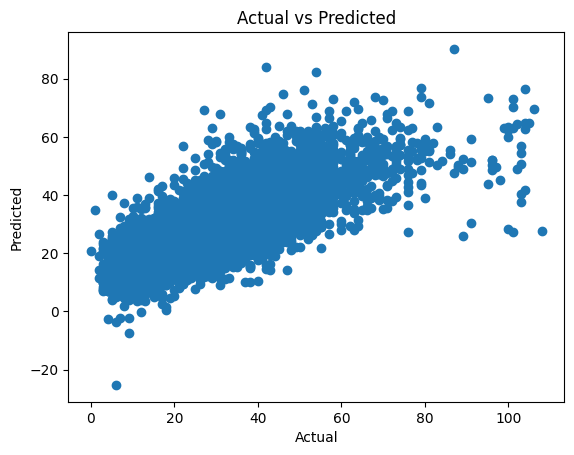

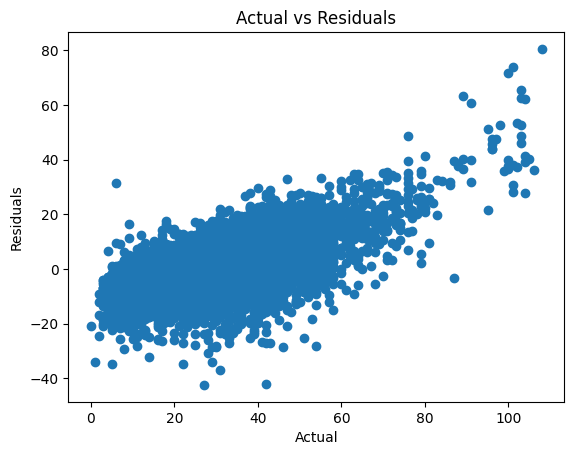

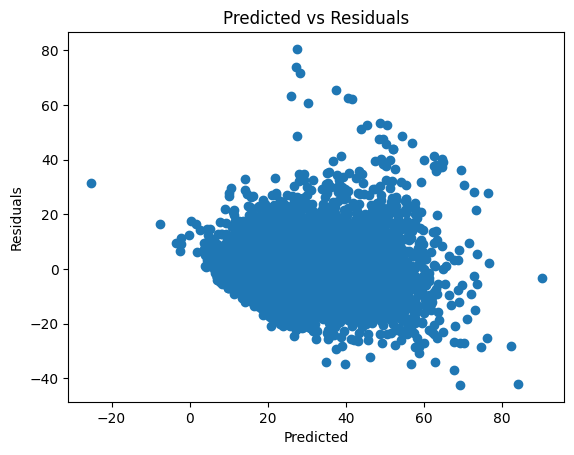

In [ ]:
# preform a linear regression on the data to predict the pollution level
topredict = 'NO2 AQI'
model_data = merged_data.copy()

# create a list of numeric columns
numeric_columns = model_data.select_dtypes(include=['float64', 'int64']).columns
# drop WS_Latitude, WS_Longitude from numeric_columns
numeric_columns = numeric_columns.drop(['WS_Latitude', 'WS_Longitude'])
# find related fields to topredict
related_fields = [col for col in model_data.columns if topredict[:3] in col or topredict[:4] in col]
related_numeric_fields = [col for col in related_fields if col in numeric_columns]
# drop related_numeric_fields from numeric_columns
numeric_columns = numeric_columns.drop(related_numeric_fields)
# print topredict and related_fields
print('Column to predict and relatives:', topredict, related_fields, related_numeric_fields)
'output list of numeric columns'
print('Output list of numeric columns:',numeric_columns)

# split data into features and target
X = model_data[numeric_columns]
y = model_data[topredict]

'output shape of X and y'
print(X.shape, y.shape)
# check for missing values in X and y
missing_values_X = X.isna().sum().sum()
missing_values_y = y.isna().sum()
'output missing values in X and y'
print(missing_values_X, missing_values_y)

# print list of fields in X
print(X.columns)

# print list of fields in y
print(y.name)

# print of list of fields in X with missing values
print(X.columns[X.isna().sum() > 0])

# print list of fields in y with missing values
print(y.name, y.isna().sum())


# split data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# create a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# predict the target using the model
y_pred = model.predict(X_test)

# calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print("mean square error:",mse)

n = len(y_test)
p = X_test.shape[1]

rss = np.sum((y_test - y_pred) ** 2)
rse = np.sqrt(rss / (n - p - 1))

print("Residual Standard Error (RSE):", rse)
print("Standard deviation of actual NO2 AQI:", y_test.std())
if rse < y_test.std():
    print("The model is better than using the mean value")
else:
    print("The model is not better than using the mean value")


# save the model


modelname = f'ML_Models/Linear_Regression_{topredict}_Model_transformed.pkl'
joblib.dump(model, modelname)

# help me understand the mse value
# calculate the mean of the target
y_mean = y.mean()
# calculate the sum of squares
ss_total = ((y - y_mean) ** 2).sum()
# calculate the r squared value
r_squared = 1 - (mse / ss_total)
r_squared

# plot the predicted values against the actual values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

# plot the residuals
residuals = y_test - y_pred
plt.scatter(y_test, residuals)
plt.xlabel('Actual')
plt.ylabel('Residuals')
plt.title('Actual vs Residuals')
plt.show()

# plot the residuals against the predicted values
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Predicted vs Residuals')
plt.show()


    

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
import joblib


def run_pollution_forecast_model(data: pd.DataFrame, topredict: str, model_save_path: str = None):
    print(f"\n🚀 Running model for: {topredict}")

    #columns to be used in model
    targets = ['O3_AQI_Group', 'SO2_AQI_Group', 'CO_AQI_Group', 'NO2_AQI_Group']

    # weather columns for model building
    weather_columns = ['Year', 'AWND', 'PGTM', 'PRCP', 'TAVG', 'TMAX', 'TMIN', 'WDMV',
                    'WT01', 'WT02', 'WT03', 'WT04', 'WT05', 'WT06', 'WT08', 'WT09', 'WT11', 'WT13',
                    'WT16', 'WT18', 'WT22', 'WS_Elevation', 'CityDistance', 'WS_Latitude', 'WS_Longitude']

    # confirm that data contains the required columns
    missing_columns = [col for col in weather_columns if col not in data.columns]
    if missing_columns:
        raise ValueError(f"Missing columns in data: {missing_columns}")

    # Step 0: Filter data for relevant columns
    data = data[weather_columns + targets+ date_columns].copy()

    # Step 1: Identify numeric features and remove coordinates
    numeric_columns = data.select_dtypes(include=["float64", "int64"]).columns.tolist()


    # Step 2: Remove features directly related to the pollutant
    related_numeric_fields = [col for col in targets if col in numeric_columns]

    print(f"🧹 Dropping related pollutant features: {related_numeric_fields}")
    feature_columns = [col for col in numeric_columns if col not in related_numeric_fields]

    # Step 3: Create feature and target sets
    Xt = data[feature_columns].copy()
    yt = data[topredict].copy()

    # Handle missing values
    Xt = Xt.dropna()
    yt = yt.loc[Xt.index]
    
    print(f"✅ Input shape: {Xt.shape}, Target shape: {yt.shape}")

    # Step 4: Scale features
    scaler = StandardScaler()
    Xt_scaled = scaler.fit_transform(Xt)

    # Step 5: Split data
    X_train, X_test, y_train, y_test = train_test_split(Xt_scaled, yt, test_size=0.2, random_state=42)

    # Step 6: Fit Linear Regression model
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Step 7: Evaluate performance
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"📉 Mean Squared Error: {mse:.2f}")
    print(f"📈 R² Score: {r2:.4f}")

    # Optional: Save the model
    if model_save_path:
        joblib.dump(model, model_save_path)
        print(f"💾 Model saved to: {model_save_path}")

    # Step 8: Visualizations
    plt.figure(figsize=(6, 4))
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"Actual vs Predicted: {topredict}")
    plt.grid(True)
    plt.show()

    residuals = y_test - y_pred
    plt.figure(figsize=(6, 4))
    plt.scatter(y_test, residuals, alpha=0.6)
    plt.xlabel("Actual")
    plt.ylabel("Residuals")
    plt.title("Actual vs Residuals")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(6, 4))
    plt.scatter(y_pred, residuals, alpha=0.6)
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.title("Predicted vs Residuals")
    plt.grid(True)
    plt.show()

    # Step 9: Feature importance test (optional)
    selector = SelectKBest(score_func=f_regression, k="all")
    selector.fit(Xt_scaled, yt)
    scores = pd.Series(selector.scores_, index=feature_columns).sort_values(ascending=False)

    print("\n📊 Feature importance (F-scores):")
    print(scores.round(2))


In [41]:
# Example usage:
run_pollution_forecast_model(merged_data_for_model, topredict="NO2_AQI_Group", model_save_path="ML_Models/NO2_AQI_Model.pkl")



🚀 Running model for: NO2_AQI_Group


ValueError: Missing columns in data: ['TSUN']


🚀 Running model for: O3_AQI_Group
🧹 Dropping related pollutant features: ['O3_AQI_Group']
✅ Input shape: (46054, 27), Target shape: (46054,)
📉 Mean Squared Error: 0.10
📈 R² Score: 0.0351
💾 Model saved to: ML_Models/O3_AQI_Model.pkl


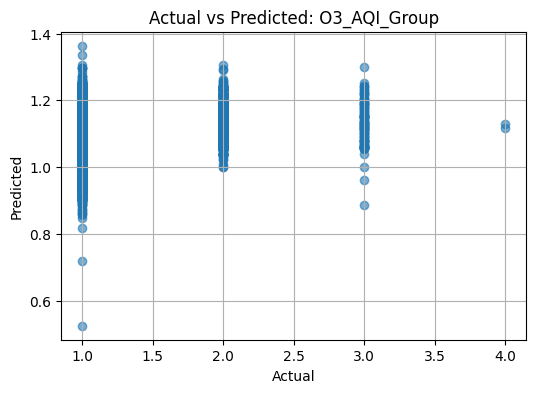

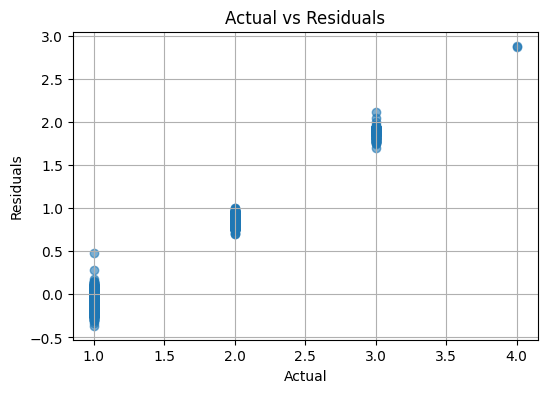

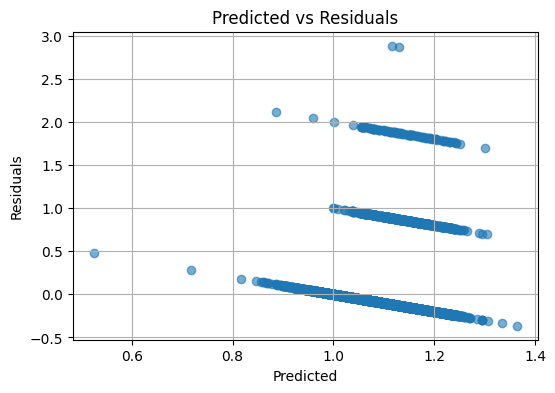


📊 Feature importance (F-scores):
TMIN             501.11
CityDistance     349.60
NO2_AQI_Group    176.98
TMAX             124.80
TAVG              85.35
Year              55.48
WT01              25.45
SO2_AQI_Group     16.32
WT18              15.56
WT02               8.34
WT22               7.08
WDMV               4.65
PGTM               4.45
AWND               3.56
WT03               3.14
WT06               3.13
WT16               3.02
WT04               2.53
WT13               2.43
WT08               1.95
WT09               0.74
WT05               0.57
WS_Elevation       0.43
CO_AQI_Group       0.30
PRCP               0.00
WT11               0.00
TSUN               0.00
dtype: float64


In [20]:
# Example usage:
run_pollution_forecast_model(merged_data_for_model, topredict="O3_AQI_Group", model_save_path="ML_Models/O3_AQI_Model.pkl")



🚀 Running model for: CO_AQI_Group
🧹 Dropping related pollutant features: ['CO_AQI_Group']
✅ Input shape: (46054, 27), Target shape: (46054,)
📉 Mean Squared Error: 0.00
📈 R² Score: -0.0119
💾 Model saved to: ML_Models/CO_AQI_Model.pkl


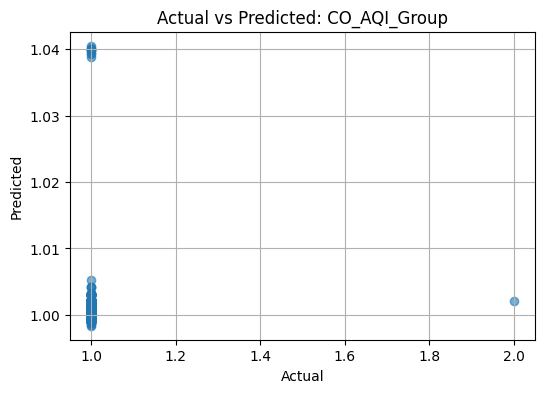

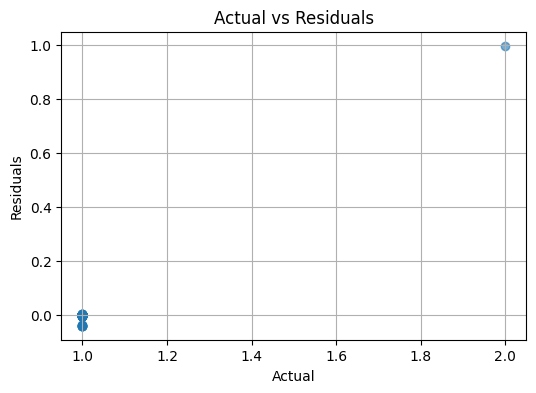

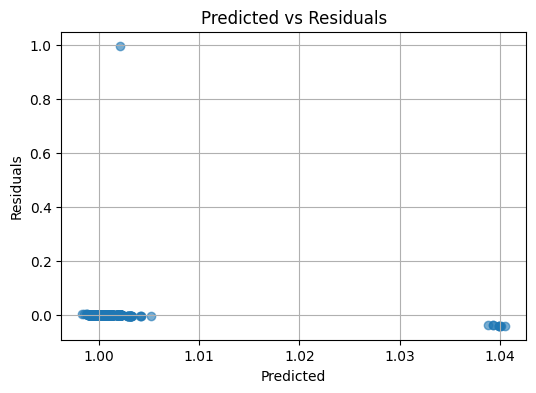


📊 Feature importance (F-scores):
WT04             339.38
NO2_AQI_Group     78.48
SO2_AQI_Group     19.93
Year              10.07
WT03               8.47
WS_Elevation       1.16
TMAX               0.71
TMIN               0.69
AWND               0.57
PGTM               0.52
PRCP               0.41
O3_AQI_Group       0.30
WT01               0.22
TAVG               0.15
CityDistance       0.13
WT08               0.10
WT13               0.08
WT16               0.06
WT02               0.03
WT18               0.02
WDMV               0.01
WT22               0.01
WT06               0.00
WT05               0.00
WT11               0.00
WT09               0.00
TSUN               0.00
dtype: float64


In [21]:
# Example usage:
run_pollution_forecast_model(merged_data_for_model, topredict="CO_AQI_Group", model_save_path="ML_Models/CO_AQI_Model.pkl")



🚀 Running model for: SO2_AQI_Group
🧹 Dropping related pollutant features: ['SO2_AQI_Group']
✅ Input shape: (46054, 27), Target shape: (46054,)
📉 Mean Squared Error: 0.01
📈 R² Score: 0.0096
💾 Model saved to: ML_Models/SO2_AQI_Model.pkl


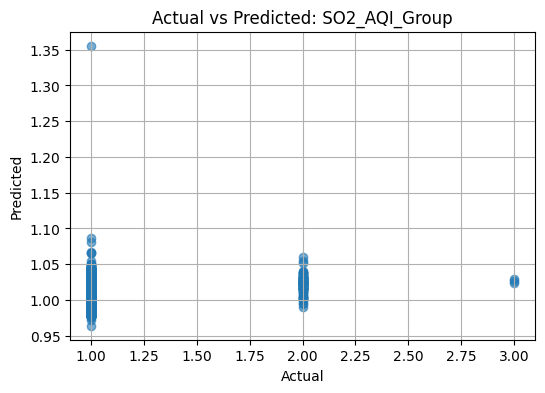

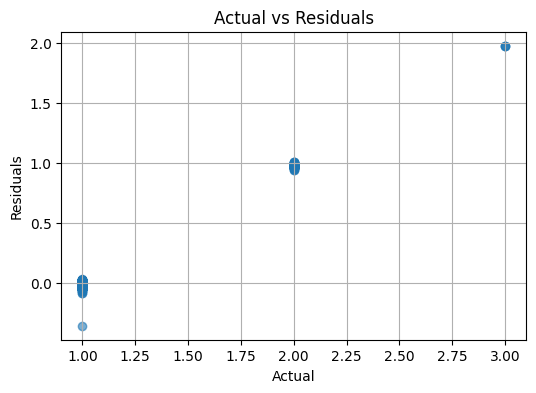

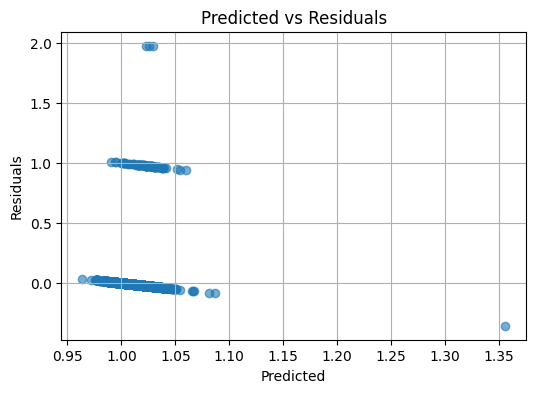


📊 Feature importance (F-scores):
Year             171.42
NO2_AQI_Group     49.82
TMIN              33.90
TMAX              25.84
CityDistance      20.64
CO_AQI_Group      19.93
O3_AQI_Group      16.32
PGTM              15.87
WT05               5.39
WT13               5.21
AWND               3.48
WT16               3.24
WT18               2.28
WT03               2.03
WDMV               1.41
TAVG               1.34
WT04               1.04
WT11               1.04
WT22               0.94
WT02               0.91
PRCP               0.65
WT08               0.45
WT06               0.42
WT09               0.10
WT01               0.06
WS_Elevation       0.03
TSUN               0.00
dtype: float64


In [22]:
# Example usage:
run_pollution_forecast_model(merged_data_for_model, topredict="SO2_AQI_Group", model_save_path="ML_Models/SO2_AQI_Model.pkl")


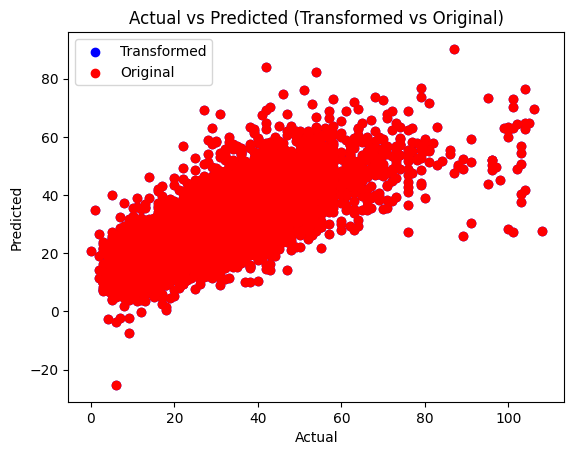

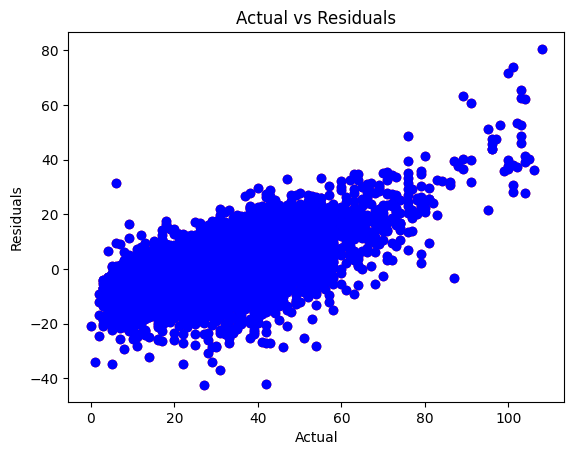

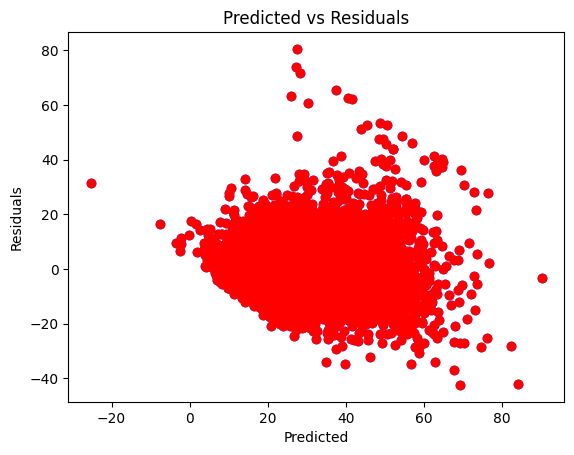

In [ ]:
# produce graphs which overlay the model predicitions prior and post transformation using the output from above

# plot the predicted values against the actual values for Transformed and Original on the same plot
plt.scatter(yt_test, yt_pred, color='blue', label='Transformed')
plt.scatter(y_test, y_pred, color='red', label='Original')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted (Transformed vs Original)')
plt.legend()
plt.show()

# plot the residuals
t_residuals = yt_test - yt_pred
residuals = y_test - y_pred
plt.scatter(y_test, residuals, color='red', label='Original')
plt.scatter(yt_test, t_residuals, color='blue', label='Transformed')
plt.xlabel('Actual')
plt.ylabel('Residuals')
plt.title('Actual vs Residuals')
plt.legend()
plt.show()

# plot the residuals against the predicted values
plt.scatter(yt_pred, t_residuals, color='blue', label='Transformed')
plt.scatter(y_pred, residuals, color='red', label='Original')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Predicted vs Residuals')
plt.legend()
plt.show()


Load model and predict


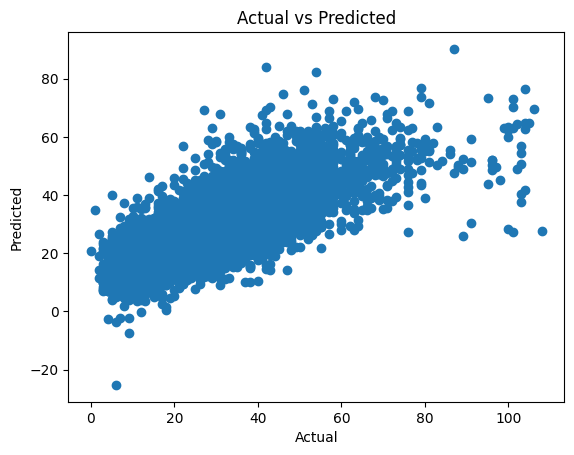

In [25]:
# load the model
model = joblib.load('Outputs/Linear_Regression_Model.pkl')

# predict the target using the model
y_pred = model.predict(X_test)

# calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
mse

# create a dataframe of the coefficients
coefficients = pd.DataFrame(model.coef_, index=numeric_columns, columns=['Coefficient'])
coefficients

# create a dataframe of the intercept
intercept = pd.DataFrame([model.intercept_], index=['Intercept'], columns=['Value'])
intercept

# save the coefficients and intercept to csv
coefficients.to_csv('Outputs/Coefficients.csv')
intercept.to_csv('Outputs/Intercept.csv')

# help me understand the outputs of the model
# calculate the mean of the target
y_mean = y.mean()
# calculate the sum of squares
ss_total = ((y - y_mean) ** 2).sum()

# calculate the r squared value
r_squared = 1 - (mse / ss_total)
r_squared

# plot the predicted values against the actual values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


def run_pollution_forecast_with_comparison(data: pd.DataFrame, topredict: str, model_save_path: str = None):
    print(f"\n🚀 Running model comparison for: {topredict}")

    # Step 1: Setup & field filtering
    numeric_columns = data.select_dtypes(include=["float64", "int64"]).columns.tolist()
    for col in ['WS_Latitude', 'WS_Longitude']:
        if col in numeric_columns:
            numeric_columns.remove(col)

    target_prefix = topredict.split()[0].lower()
    related_fields = [col for col in data.columns if col.lower().startswith(target_prefix)]
    related_numeric_fields = [col for col in related_fields if col in numeric_columns]
    feature_columns = [col for col in numeric_columns if col not in related_numeric_fields]

    print(f"🧹 Dropping related fields: {related_numeric_fields}")
    Xt = data[feature_columns].copy()
    yt = data[topredict].copy()

    Xt = Xt.dropna()
    yt = yt.loc[Xt.index]

    # Step 2: Scale features
    scaler = StandardScaler()
    Xt_scaled = scaler.fit_transform(Xt)

    # Step 3: Split data
    X_train, X_test, y_train, y_test = train_test_split(Xt_scaled, yt, test_size=0.2, random_state=42)

    # Step 4: Define models to test
    models = {
        "Linear Regression": LinearRegression(),
        "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
        "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
    }

    results = []

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        results.append({
            "Model": name,
            "MSE": mse,
            "R2": r2,
            "Predictions": y_pred,
            "Residuals": y_test - y_pred,
            "FittedModel": model
        })

        print(f"\n📊 {name}")
        print(f"  - MSE: {mse:.2f}")
        print(f"  - R²: {r2:.4f}")

        # Plot residuals
        plt.figure(figsize=(6, 4))
        plt.scatter(y_pred, y_test - y_pred, alpha=0.6)
        plt.axhline(0, color="red", linestyle="--")
        plt.xlabel("Predicted")
        plt.ylabel("Residuals")
        plt.title(f"{name} - Predicted vs Residuals")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # Step 5: Feature importance (based on Linear Regression)
    selector = SelectKBest(score_func=f_regression, k="all")
    selector.fit(Xt_scaled, yt)
    scores = pd.Series(selector.scores_, index=feature_columns).sort_values(ascending=False)

    print("\n📈 Feature importance (F-score, not model-specific):")
    print(scores.round(2))

    # Step 6: Save best model if requested
    if model_save_path:
        best_model = max(results, key=lambda x: x["R2"])
        joblib.dump(best_model["FittedModel"], model_save_path)
        print(f"\n💾 Best model ({best_model['Model']}) saved to: {model_save_path}")

    return results  # optional: return results if you want to use them later


🚀 Running model comparison for: NO2_AQI_Group
🧹 Dropping related fields: ['NO2_AQI_Group']

📊 Linear Regression
  - MSE: 0.07
  - R²: 0.0409


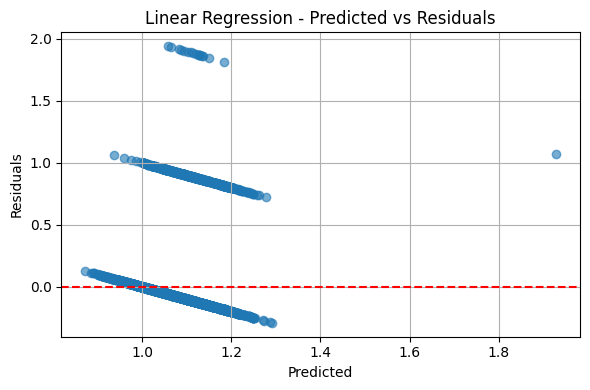


📊 Random Forest
  - MSE: 0.07
  - R²: -0.0092


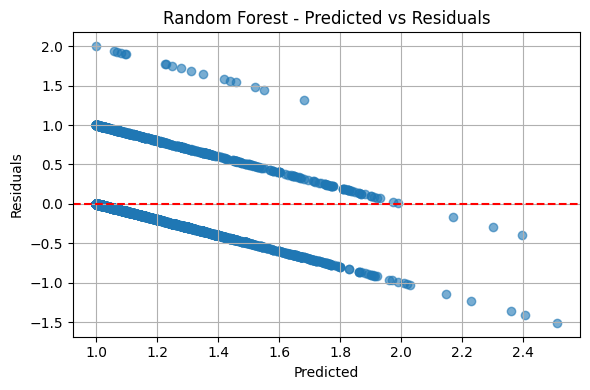


📊 Gradient Boosting
  - MSE: 0.06
  - R²: 0.1313


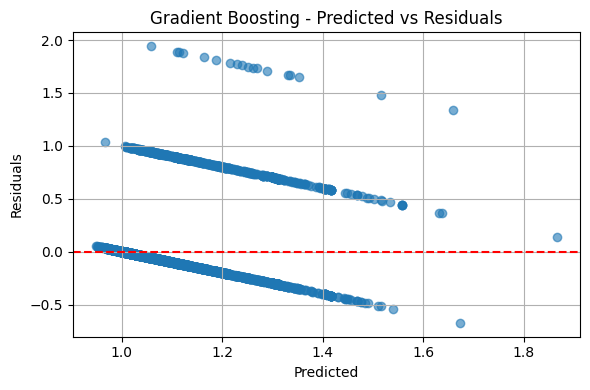


📈 Feature importance (F-score, not model-specific):
Year             545.59
AWND             338.91
CityDistance     304.93
PGTM             258.53
O3_AQI_Group     176.98
CO_AQI_Group      78.48
TAVG              70.82
WT13              57.13
SO2_AQI_Group     49.82
TMIN              48.26
WT01              38.26
WT16              37.40
TMAX              34.84
WT02              28.22
WT08              25.27
WS_Elevation      20.29
WT18              17.39
PRCP              10.80
WDMV              10.72
WT22               7.16
WT06               3.16
WT03               2.04
WT11               0.91
WT09               0.75
WT04               0.11
WT05               0.00
TSUN               0.00
dtype: float64

💾 Best model (Gradient Boosting) saved to: ML_Models/best_model_NO2.pkl


[{'Model': 'Linear Regression',
  'MSE': 0.06897344838308739,
  'R2': 0.04087269196957055,
  'Predictions': array([1.07989114, 1.09277202, 1.02612102, ..., 1.04700792, 1.14866037,
         1.01657512]),
  'Residuals': 17160   -0.079891
  19705   -0.092772
  38352   -0.026121
  31687   -0.038589
  19962   -0.063799
             ...   
  32629   -0.081186
  31178   -0.032158
  12257   -0.047008
  268      0.851340
  3142    -0.016575
  Name: NO2_AQI_Group, Length: 9211, dtype: float64,
  'FittedModel': LinearRegression()},
 {'Model': 'Random Forest',
  'MSE': 0.07257513233651483,
  'R2': -0.009211413082574671,
  'Predictions': array([1.48416667, 1.        , 1.        , ..., 1.        , 1.58116667,
         1.        ]),
  'Residuals': 17160   -0.484167
  19705    0.000000
  38352    0.000000
  31687    0.000000
  19962   -0.130183
             ...   
  32629   -0.160000
  31178   -0.030000
  12257    0.000000
  268      0.418833
  3142     0.000000
  Name: NO2_AQI_Group, Length: 9211, dt

In [25]:
run_pollution_forecast_with_comparison(
    data=merged_data_for_model,
    topredict="NO2_AQI_Group",
    model_save_path="ML_Models/best_model_NO2.pkl"
)


🚀 Running model comparison for: O3_AQI_Group
🧹 Dropping related fields: ['O3_AQI_Group']

📊 Linear Regression
  - MSE: 0.10
  - R²: 0.0351


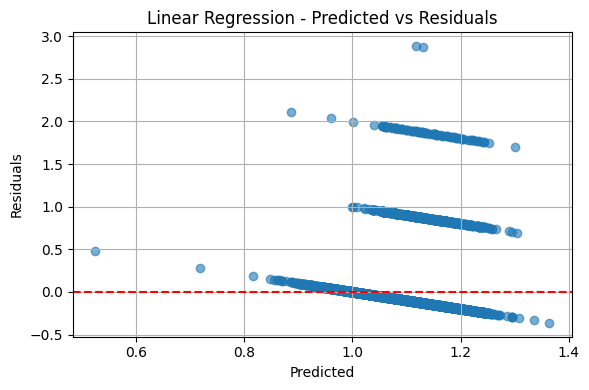


📊 Random Forest
  - MSE: 0.10
  - R²: 0.0358


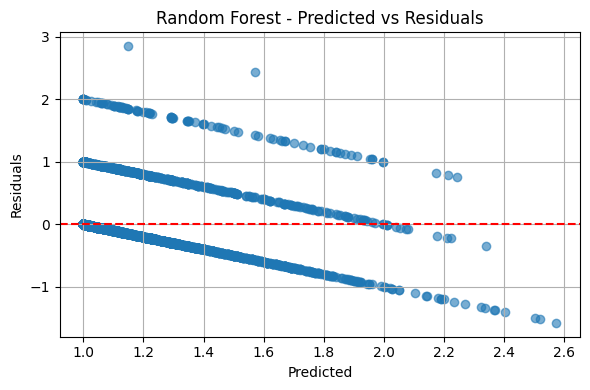


📊 Gradient Boosting
  - MSE: 0.09
  - R²: 0.0952


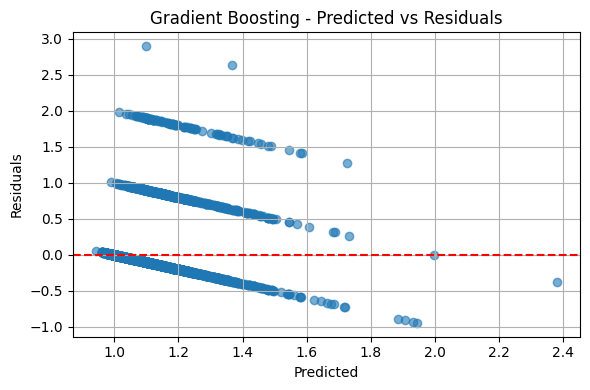


📈 Feature importance (F-score, not model-specific):
TMIN             501.11
CityDistance     349.60
NO2_AQI_Group    176.98
TMAX             124.80
TAVG              85.35
Year              55.48
WT01              25.45
SO2_AQI_Group     16.32
WT18              15.56
WT02               8.34
WT22               7.08
WDMV               4.65
PGTM               4.45
AWND               3.56
WT03               3.14
WT06               3.13
WT16               3.02
WT04               2.53
WT13               2.43
WT08               1.95
WT09               0.74
WT05               0.57
WS_Elevation       0.43
CO_AQI_Group       0.30
PRCP               0.00
WT11               0.00
TSUN               0.00
dtype: float64

💾 Best model (Gradient Boosting) saved to: ML_Models/best_model_O3.pkl


[{'Model': 'Linear Regression',
  'MSE': 0.10005542609807172,
  'R2': 0.0350853230691659,
  'Predictions': array([1.06639265, 1.06105492, 1.07171293, ..., 1.06989413, 1.10954091,
         1.21046712]),
  'Residuals': 17160   -0.066393
  19705   -0.061055
  38352   -0.071713
  31687   -0.103222
  19962   -0.075489
             ...   
  32629    0.013106
  31178   -0.068982
  12257   -0.069894
  268     -0.109541
  3142    -0.210467
  Name: O3_AQI_Group, Length: 9211, dtype: float64,
  'FittedModel': LinearRegression()},
 {'Model': 'Random Forest',
  'MSE': 0.0999798353963014,
  'R2': 0.03581430479881442,
  'Predictions': array([1.  , 1.28, 1.  , ..., 1.  , 1.  , 1.  ]),
  'Residuals': 17160    0.00
  19705   -0.28
  38352    0.00
  31687    0.00
  19962    0.00
           ... 
  32629    0.00
  31178    0.00
  12257    0.00
  268      0.00
  3142     0.00
  Name: O3_AQI_Group, Length: 9211, dtype: float64,
  'FittedModel': RandomForestRegressor(random_state=42)},
 {'Model': 'Gradient Bo

In [26]:
run_pollution_forecast_with_comparison(
    data=merged_data_for_model,
    topredict="O3_AQI_Group",
    model_save_path="ML_Models/best_model_O3.pkl"
)


🚀 Running model comparison for: CO AQI
🧹 Dropping related fields: ['County Code', 'CO Mean', 'CO 1st Max Value', 'CO 1st Max Hour', 'CO AQI', 'CO_AQI_Group']

📊 Linear Regression
  - MSE: 14.90
  - R²: 0.5152


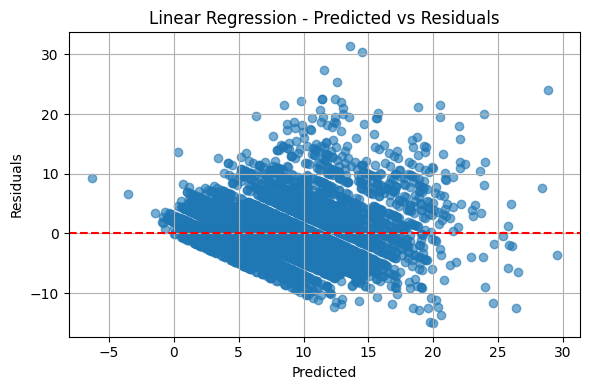


📊 Random Forest
  - MSE: 9.55
  - R²: 0.6893


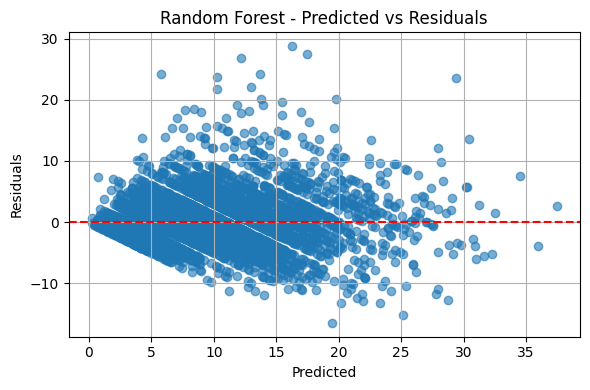


📊 Gradient Boosting
  - MSE: 10.99
  - R²: 0.6423


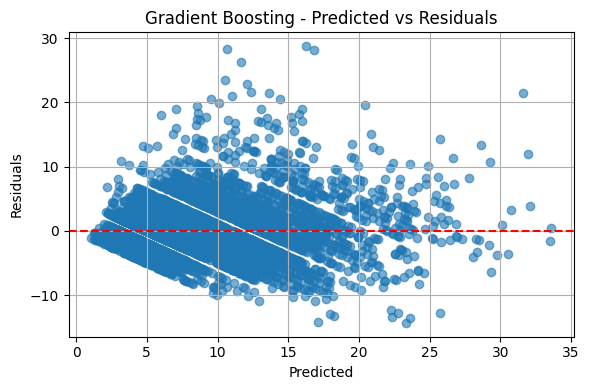


📈 Feature importance (F-score, not model-specific):
NO2 Mean             30726.63
NO2 AQI              22563.47
NO2 1st Max Value    22257.67
NO2_AQI_Group        10058.28
O3 Mean               6311.81
SO2 Mean              4546.48
year                  3639.97
Year                  3639.97
State Code            3574.66
SO2 AQI               2894.74
SO2 1st Max Value     2619.17
O3 1st Max Value      1891.12
Site Num              1646.61
TMIN                  1139.92
O3 AQI                1135.58
WS_Elevation          1108.47
TMAX                   271.56
SO2 1st Max Hour       249.00
SO2_AQI_Group           93.87
AWND                    90.57
PRCP                    82.76
WDMV                    67.78
PGTM                    59.65
O3 1st Max Hour         51.62
WT16                    34.32
NO2 1st Max Hour        22.69
O3_AQI_Group            17.65
WT06                    16.91
WT13                    16.45
WT18                    14.62
WT05                     8.98
WT22             

[{'Model': 'Linear Regression',
  'MSE': 14.896974763230558,
  'R2': 0.5152053720534049,
  'Predictions': array([14.36481349,  7.8918601 ,  0.60345716, ...,  4.13473315,
         22.0525546 ,  7.25629261]),
  'Residuals': 17160     4.635187
  19705    -4.891860
  38352     1.396543
  31687     0.569090
  19962    -3.374575
             ...    
  32629    -3.410144
  31178    -4.549063
  12257     5.865267
  268      11.947445
  3142     -1.256293
  Name: CO AQI, Length: 9211, dtype: float64,
  'FittedModel': LinearRegression()},
 {'Model': 'Random Forest',
  'MSE': 9.547969156443383,
  'R2': 0.6892789154568095,
  'Predictions': array([17.52,  5.18,  1.88, ...,  6.38, 32.47,  7.03]),
  'Residuals': 17160    1.48
  19705   -2.18
  38352    0.12
  31687   -3.07
  19962   -0.87
           ... 
  32629    0.42
  31178   -0.93
  12257    3.62
  268      1.53
  3142    -1.03
  Name: CO AQI, Length: 9211, dtype: float64,
  'FittedModel': RandomForestRegressor(random_state=42)},
 {'Model': 'Gra

In [69]:
run_pollution_forecast_with_comparison(
    data=merged_data,
    topredict="CO AQI",
    model_save_path="ML_Models/best_model_CO.pkl"
)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


def run_pollution_classification(data: pd.DataFrame, target_col: str, model_save_path: str = None):
    """_summary_

    Args:
        data (pd.DataFrame): _description_
        target_col (str): _description_
        model_save_path (str, optional): _description_. Defaults to None.

    Returns:
        _type_: _description_

    Group	WT Codes	Description
    Precipitation	 WT08, WT02, WT09, WT11	 Thunderstorm, Mist, drizzle, showers
    Wind	WT06, WT13	Blowing dust/snow
    Extreme	 WT18, WT22	tornado, hail
    Other	 WT03, WT16, WT01, WT04, WT05,	 smog, other, Fog, haze, smoke,
    """
    print(f"\n🚀 Running classification model for: {target_col}")

    # ======== Step 1: Group WT Columns =========
    precip_cols = ['WT08', 'WT02', 'WT09', 'WT11']
    wind_cols = ['WT06', 'WT13']
    extreme_cols = ['WT18', 'WT22']
    other_cols = ['WT01', 'WT02', 'WT04', 'WT05', 'WT03', 'WT16']

    # Create grouped weather features
    data["WT_Precip"] = data[precip_cols].sum(axis=1)
    data["WT_Wind"] = data[wind_cols].sum(axis=1)
    data["WT_Extreme"] = data[extreme_cols].sum(axis=1)
    data["WT_Other"] = data[other_cols].sum(axis=1)

    # Drop original WT columns
    all_wt_cols = precip_cols + wind_cols + extreme_cols + other_cols
    data.drop(columns=[col for col in all_wt_cols if col in data.columns], inplace=True)

    # ======== Step 2: Prepare Features & Target =========
    numeric_columns = data.select_dtypes(include=["float64", "int64"]).columns.tolist()

    # drop any of the other columns in targets from numeric_columns
    related_fields = [col for col in data.columns if target_col.lower() in col.lower()]
    

    # Avoid data leakage
    feature_columns = [col for col in numeric_columns if col not in related_numeric_fields]

    print(f"🧹 Dropping related fields: {related_numeric_fields}")
    Xt = data[feature_columns].copy()
    yt = data[target_col].copy()

    Xt = Xt.dropna()
    yt = yt.loc[Xt.index]

    # ======== Step 3: Scale Features =========
    scaler = StandardScaler()
    Xt_scaled = scaler.fit_transform(Xt)

    # ======== Step 4: Train/Test Split =========
    X_train, X_test, y_train, y_test = train_test_split(Xt_scaled, yt, test_size=0.2, random_state=42)

    # ======== Step 5: Define Classifiers =========
    models = {
        "Logistic Regression": LogisticRegression(max_iter=500, class_weight='balanced'),
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
        "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42)
    }

    results = []

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        print(f"\n📊 {name}")
        print(f"  - Accuracy: {acc:.4f}")
        print("  - Classification Report:")
        print(classification_report(y_test, y_pred, zero_division=0))

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title(f"{name} - Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.tight_layout()
        plt.show()

        results.append({
            "Model": name,
            "Accuracy": acc,
            "FittedModel": model,
            "Predictions": y_pred
        })

    # ======== Step 6: Feature Importance (F-score) =========
    selector = SelectKBest(score_func=f_classif, k="all")
    selector.fit(Xt_scaled, yt)
    scores = pd.Series(selector.scores_, index=feature_columns).sort_values(ascending=False)

    print("\n📈 Feature importance (ANOVA F-score):")
    print(scores.round(2))

    # ======== Step 7: Save Best Model =========
    if model_save_path:
        best_model = max(results, key=lambda x: x["Accuracy"])
        joblib.dump(best_model["FittedModel"], model_save_path, compress=3)
        print(f"\n💾 Best model ({best_model['Model']}) saved to: {model_save_path}")

    return results



🚀 Running classification model for: NO2_AQI_Group
🧹 Dropping related fields: ['NO2_AQI_Group']

📊 Logistic Regression
  - Accuracy: 0.5698
  - Classification Report:
              precision    recall  f1-score   support

           1       0.96      0.58      0.72      8553
           2       0.12      0.41      0.19       640
           3       0.01      0.61      0.01        18

    accuracy                           0.57      9211
   macro avg       0.36      0.53      0.31      9211
weighted avg       0.90      0.57      0.69      9211



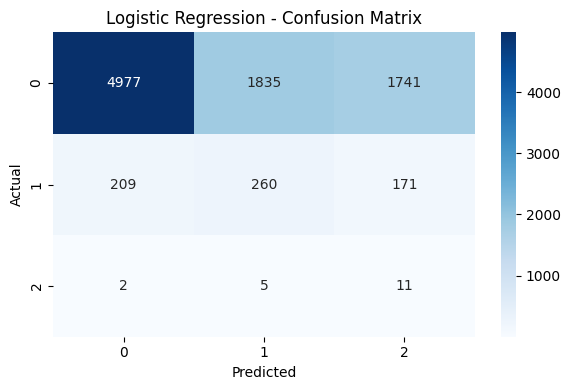


📊 Random Forest
  - Accuracy: 0.9176
  - Classification Report:
              precision    recall  f1-score   support

           1       0.94      0.98      0.96      8553
           2       0.30      0.12      0.17       640
           3       0.00      0.00      0.00        18

    accuracy                           0.92      9211
   macro avg       0.41      0.37      0.37      9211
weighted avg       0.89      0.92      0.90      9211



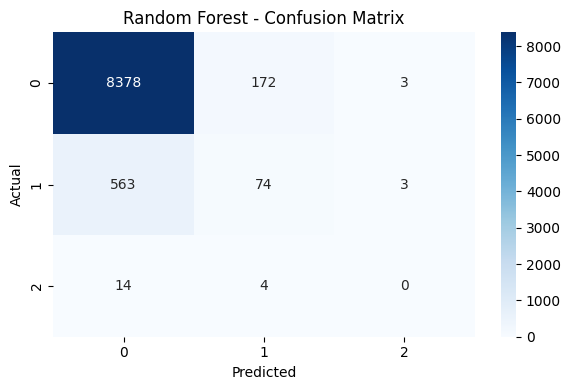


📊 Gradient Boosting
  - Accuracy: 0.9283
  - Classification Report:
              precision    recall  f1-score   support

           1       0.93      1.00      0.96      8553
           2       0.47      0.02      0.04       640
           3       0.00      0.00      0.00        18

    accuracy                           0.93      9211
   macro avg       0.47      0.34      0.34      9211
weighted avg       0.90      0.93      0.90      9211



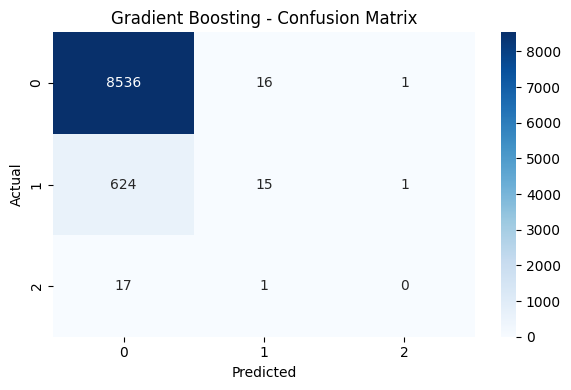


📈 Feature importance (ANOVA F-score):
CO_AQI_Group     324.25
Year             275.08
CityDistance     191.15
AWND             172.84
PGTM             132.68
O3_AQI_Group      89.11
TAVG              37.58
TMAX              32.39
TMIN              30.32
WT_Other          30.19
WT_Wind           29.70
SO2_AQI_Group     25.15
WT_Precip         22.25
WS_Elevation      13.60
WT_Extreme         9.09
WDMV               5.48
PRCP               5.43
TSUN                NaN
dtype: float64

💾 Best model (Gradient Boosting) saved to: ML_Models/best_classifier_NO2.pkl


h:\VScode\March Group\March_Team_Project\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [7] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
h:\VScode\March Group\March_Team_Project\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [32]:
# Run classification model
results = run_pollution_classification(
    data=merged_data_for_model,
    target_col='NO2_AQI_Group',
    model_save_path='ML_Models/best_classifier_NO2.pkl'
)